In [169]:
# Vamos a realizar una prueba solo son la prediccion de latitudes
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

#Cargamos el Dataset
file_path = "dataset/dataset.csv"
df = pd.read_csv(file_path)


In [170]:
X_columns = [
    'latitude_pos_tx', 'longitude_pos_tx', 'elevation_pos_tx', 'fc', 'elevation', 
    'azimuth', 'year', 'mmdd', 'UTI', 'hour', 'delay', 'terrestrial_range', 
    'slant_range', 'final_latitude', 'final_longitude', 'final_elevation'
]
X = df[X_columns]
Y = df.drop(columns=X_columns)

# No corresponden a X
X = X.drop(columns=['final_latitude','final_longitude','final_elevation'])

# Nombres de las columnas
lat_columns = [f'lat_{i}' for i in range(1,101)]
long_columns = [f'long_{i}' for i in range(1,101)]
elev_columns = [f'elev_{i}' for i in range(1,101)]

# Quito longitudes y elevaciones
Y = Y.drop(columns= long_columns)
Y = Y.drop(columns = elev_columns)

# Las colomunas "delay", "terrestrial_range", "slant_range" NO lo tomaré
# en cuenta por ahora y SON parte de Y NO de X.
unwanted_columns = ["delay","terrestrial_range","slant_range"]
X = X.drop(columns=unwanted_columns)



In [171]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

In [172]:
#Normalizo fc MHz
k_norm = 1000000
x_train["fc"] = x_train["fc"]/k_norm
x_test["fc"] = x_test["fc"]/k_norm


# tomamos solo 6 decimas
y_train = y_train.round(6)
y_test = y_test.round(6)

x_test.head()

,latitude_pos_tx,longitude_pos_tx,elevation_pos_tx,fc,elevation,azimuth,year,mmdd,UTI,hour
5104,-42.28,-63.4,0,30.0,30,91,2010.0,1215,0,12
2186,-42.28,-63.4,0,10.0,5,98,2010.0,1231,0,8
4371,-42.28,-63.4,0,23.0,32,88,2010.0,1215,0,12
831,-42.28,-63.4,0,10.0,5,98,2010.0,519,0,12
1421,-42.28,-63.4,0,10.0,5,98,2010.0,825,0,20


In [173]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

In [174]:
inputs = Input(shape=(10,))
encoded = Dense(8, activation='relu')(inputs)  # Compresión
encoded = Dense(32, activation='relu')(encoded)
decoded = Dense(16, activation='relu')(encoded)
decoded = Dense(100, activation='linear')(encoded)  # Reconstrucción a 100 puntos


autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 8)              │            88 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 100)            │         3,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,676 (14.36 KB)

 Trainable params: 3,676 (14.36 KB)

 Non-trainable params: 0 (0.00 B)

In [175]:
# Entrenamiento 
print(len(x_train))
history = autoencoder.fit(x_train,y_train,
                          epochs=80,batch_size=70, 
                          validation_data = (x_test,y_test))  

## epochs=70 y batch_size = 40 con solo dos capas mejores resultados 


4104
Epoch 1/80
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 13287.8828 - val_loss: 1392.2107
Epoch 2/80
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 851.5278 - val_loss: 151.3490
Epoch 3/80
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 98.9447 - val_loss: 35.2213
Epoch 4/80
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25.3339 - val_loss: 11.2205
Epoch 5/80
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.6301 - val_loss: 4.5513
Epoch 6/80
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0169 - val_loss: 2.7927
Epoch 7/80
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6394 - val_loss: 2.2348
Epoch 8/80
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1996 - val_loss: 2.0734
Epoch 9/80
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1371 - val_loss: 1.8290
Epoch 10/80
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8870 - val_loss: 1.6765
Epoch 11/80
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7007 - val_loss: 1.4923
Epoch 12/80
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - l

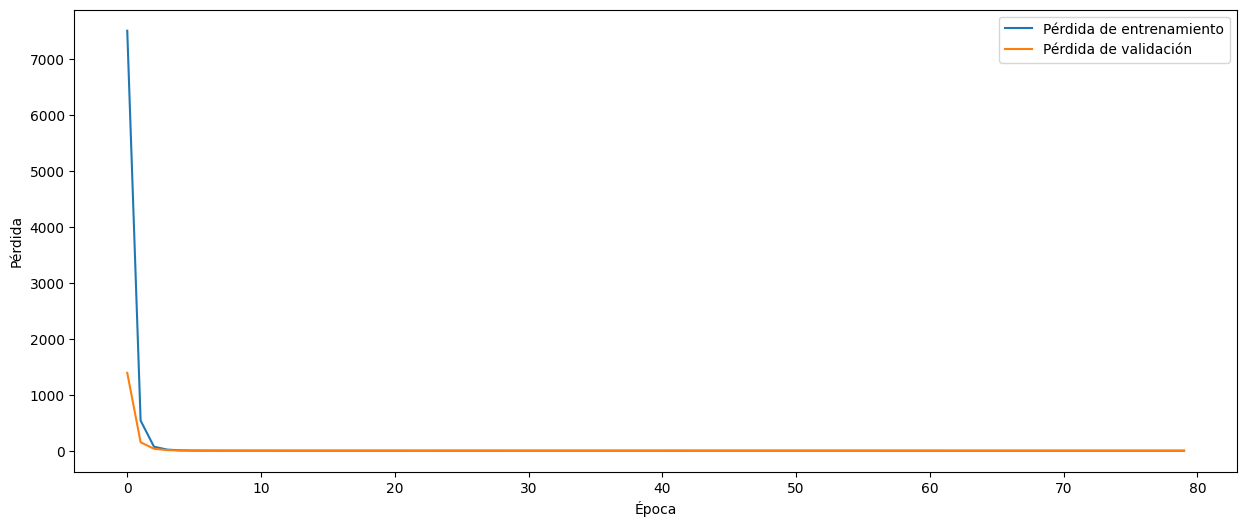

In [176]:
import matplotlib.pyplot as plt

# Graficar la función de pérdida durante el entrenamiento
plt.figure(figsize=(15, 6))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [177]:
# Evaluar el modelo en los datos de prueba
loss = autoencoder.evaluate(x_test, y_test)
print(f'Pérdida en datos de prueba: {loss}')

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6238
Pérdida en datos de prueba: 0.5681110620498657


In [178]:
# Realizar predicciones con el conjunto de prueba
predicciones = autoencoder.predict(x_test)

# Mostrar una predicción
print(type(predicciones))
print(predicciones)  # Muestra los primeros 100 puntos predichos

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
<class 'numpy.ndarray'>
[[-42.505005 -42.79737  -42.89539  ... -40.783337 -40.997723 -41.32544 ]
 [-41.446102 -41.713276 -42.0054   ... -40.145756 -40.516266 -40.379005]
 [-42.64483  -42.637444 -42.59436  ... -41.177284 -41.325596 -41.597527]
 ...
 [-42.75883  -42.10737  -42.071445 ... -41.814323 -42.548473 -42.4375  ]
 [-42.016    -42.515125 -41.99217  ... -41.34503  -41.226208 -41.521107]
 [-41.996193 -41.993076 -41.45182  ... -41.152615 -40.88943  -40.890137]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


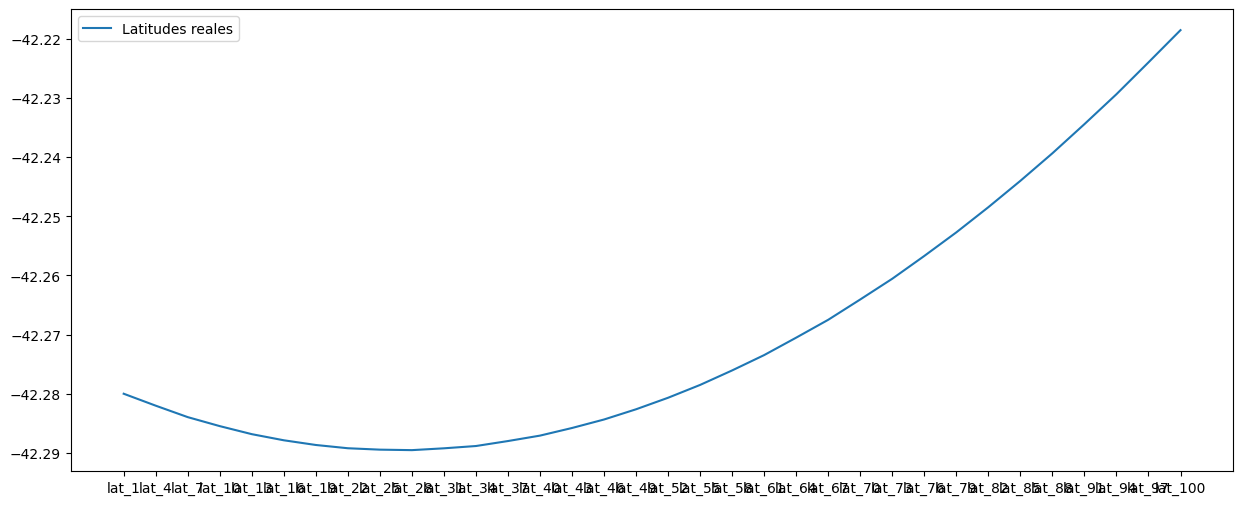

In [179]:
import matplotlib.pyplot as plt

idx = 10  # Elegir una muestra para comparar
y_pred = autoencoder.predict(np.expand_dims(x_test.iloc[idx], axis=0))  # Predicción de una muestra
y_true = y_test.iloc[idx]  # Valores reales de esa muestra

# Graficar las predicciones contra los valores reales (por ejemplo, latitudes)
plt.figure(figsize=(15, 6))
plt.plot(y_true[::3], label='Latitudes reales')
# plt.plot(y_pred[::3], label='Latitudes predichas')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
<class 'numpy.ndarray'> <class 'pandas.core.series.Series'>


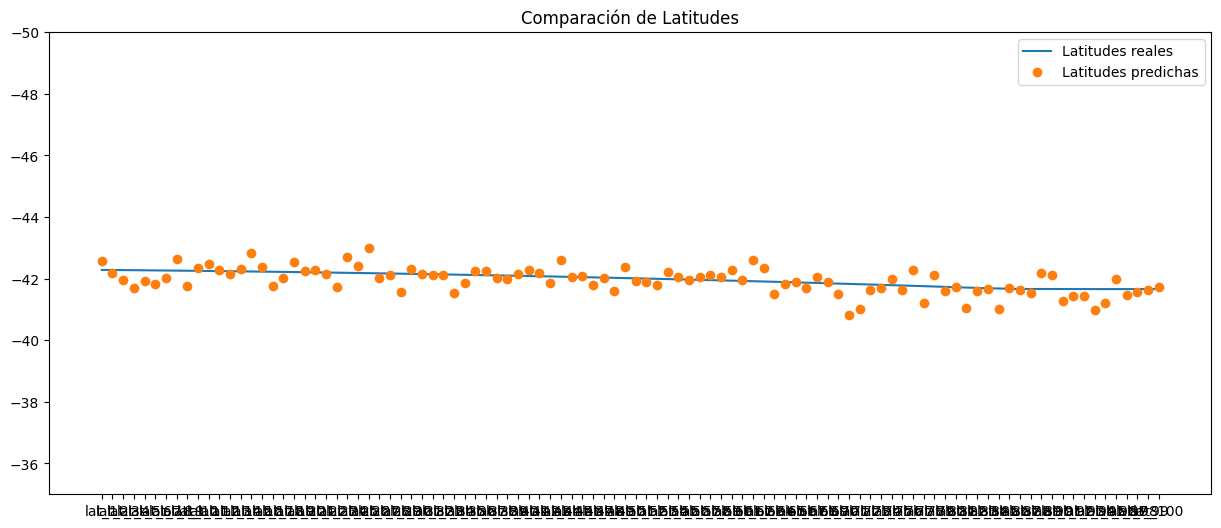

In [180]:
import matplotlib.pyplot as plt

idx = 200  # Elegir una muestra para comparar

# Predicción de una muestra
y_pred = autoencoder.predict(np.expand_dims(x_test.iloc[idx], axis=0))

# Valores reales de esa muestra
y_true = y_test.iloc[idx]
y_true = y_true[:100]
y_pred = y_pred[0,0:100]
print(type(y_pred), type(y_true))

##Graficamos 
# Latitudes
plt.figure(figsize=(15, 6))
plt.plot(y_true, label='Latitudes reales')
plt.plot(y_pred, label='Latitudes predichas', linestyle = 'None',marker='o')
plt.ylim(-35,-50) ##(-60,-30)
plt.title('Comparación de Latitudes')
plt.legend()
plt.show()